In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f_oneway

# 1. EDA

In [248]:
df = pd.read_csv('kaggleton_5_data.csv')
df.head()

,Average Gender,Average Age,Average Income,Average Number of Friends Present,Beer Price Sensitivity,Frequency of Purchase,Time of Purchase,Social Activity Score,Dance Frequency Score,Brand Loyalty Score,Flirting Score,Aggression Score,Noise Generation Level
0,0,26,3,3,3,1,2,7,1,7,3,9,9
1,0,70,1,1,3,2,1,1,1,7,3,3,2
2,0,16,1,4,8,2,3,3,1,1,1,1,7
3,0,46,5,2,2,1,1,9,2,2,3,1,3
4,0,47,5,3,2,1,1,8,1,1,2,2,3


* Check NaN values

In [249]:
nan_values ={}

for feature in df.columns:
    nan_values[feature] = df[feature].isna().sum()
print(nan_values)

{'Average Gender': 0, 'Average Age': 0, 'Average Income': 0, 'Average Number of Friends Present': 0, 'Beer Price Sensitivity': 0, 'Frequency of Purchase': 0, 'Time of Purchase': 0, 'Social Activity Score': 0, 'Dance Frequency Score': 0, 'Brand Loyalty Score': 0, 'Flirting Score': 0, 'Aggression Score': 0, 'Noise Generation Level': 0}


* Major descriptive characteristics

In [250]:
df.describe()

,Average Gender,Average Age,Average Income,Average Number of Friends Present,Beer Price Sensitivity,Frequency of Purchase,Time of Purchase,Social Activity Score,Dance Frequency Score,Brand Loyalty Score,Flirting Score,Aggression Score,Noise Generation Level
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.120000,35.076000,2.880000,2.990000,3.690000,1.472000,2.020000,5.136000,2.104000,4.178000,2.030000,3.566000,4.684000
std,0.325287,15.900688,1.340595,1.512109,2.297925,0.499715,0.817886,3.163783,1.997289,3.075913,0.840543,2.833673,3.050698
min,0.000000,16.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,24.750000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000
50%,0.000000,29.000000,3.000000,3.000000,3.000000,1.000000,2.000000,7.000000,2.000000,3.000000,2.000000,3.000000,3.000000
75%,0.000000,44.000000,3.000000,4.000000,5.000000,2.000000,3.000000,8.000000,2.000000,8.000000,3.000000,3.000000,7.000000
max,1.000000,79.000000,5.000000,5.000000,9.000000,2.000000,3.000000,9.000000,9.000000,9.000000,3.000000,9.000000,9.000000


* Pie graphs

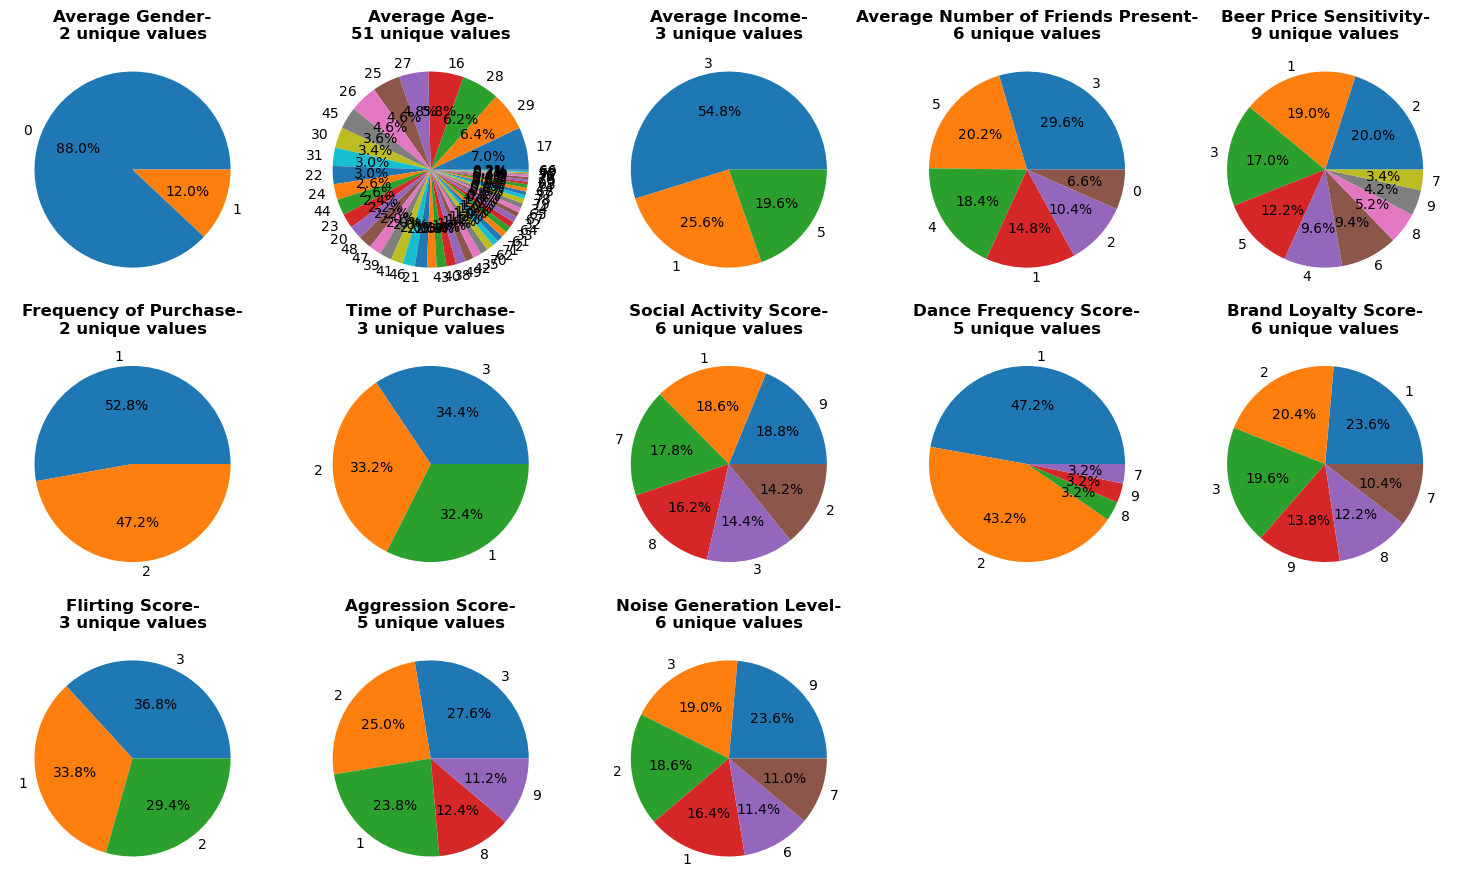

In [251]:
num_features = len(df.columns)
num_rows = (num_features + 4) // 5

fig, axis = plt.subplots(ncols=5, nrows=num_rows, figsize=(num_rows*5,num_rows*3))
axis = axis.flatten()

# build pie graph for each feature
for i, feature in enumerate(df.columns):
    df[feature].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axis[i])
    axis[i].set_title(f'{feature}-\n{df[feature].nunique()} unique values', fontweight='bold')
    axis[i].set_ylabel('')

# hide extra areas with empty graphs
for j in range(num_features, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

* Distributions

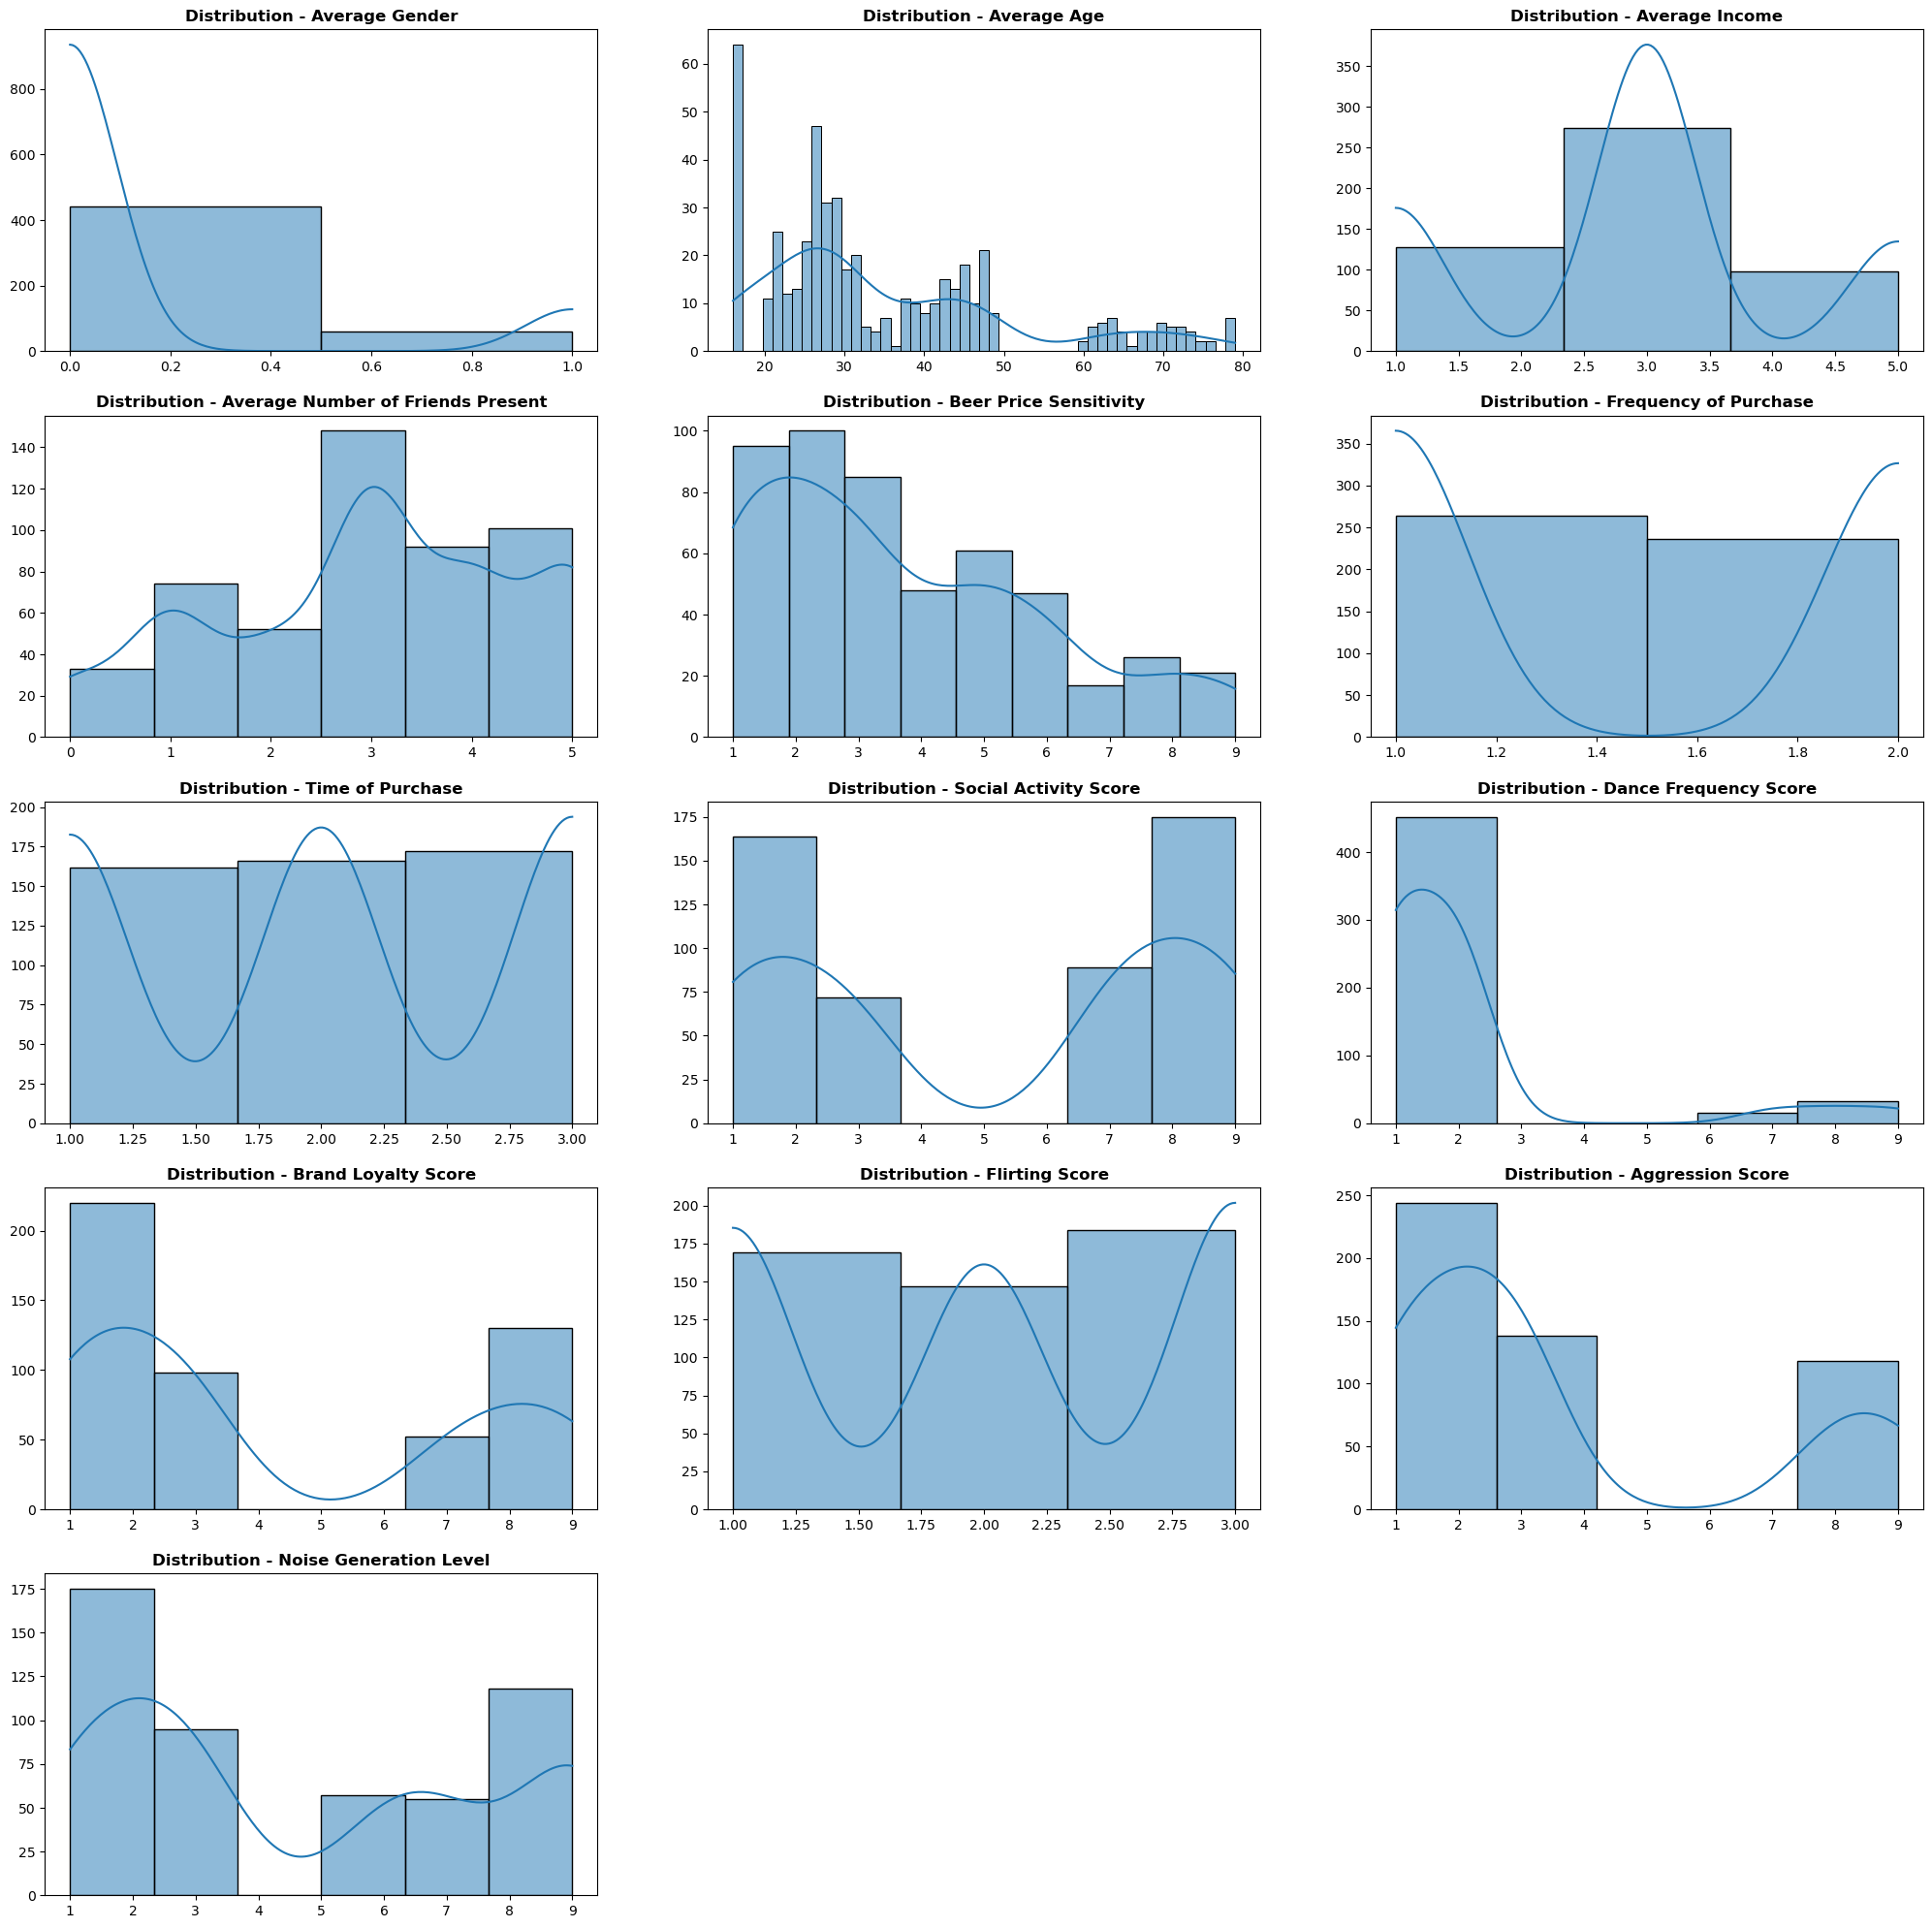

In [252]:
num_rows = (num_features + 2) // 3
fig, axis = plt.subplots(ncols=3, nrows=num_rows, figsize=(num_rows*5,num_rows*5))
axis = axis.flatten()

for i, feature in enumerate(df.columns):
    sns.histplot(df[feature], bins=df[feature].nunique(), kde=True, ax=axis[i])
    axis[i].set_title(f"Distribution - {feature}", fontweight='bold')
    axis[i].set_xlabel('')
    axis[i].set_ylabel('')

for j in range(num_features, len(axis)):
    fig.delaxes(axis[j])

plt.show()

* Correlation heatmap

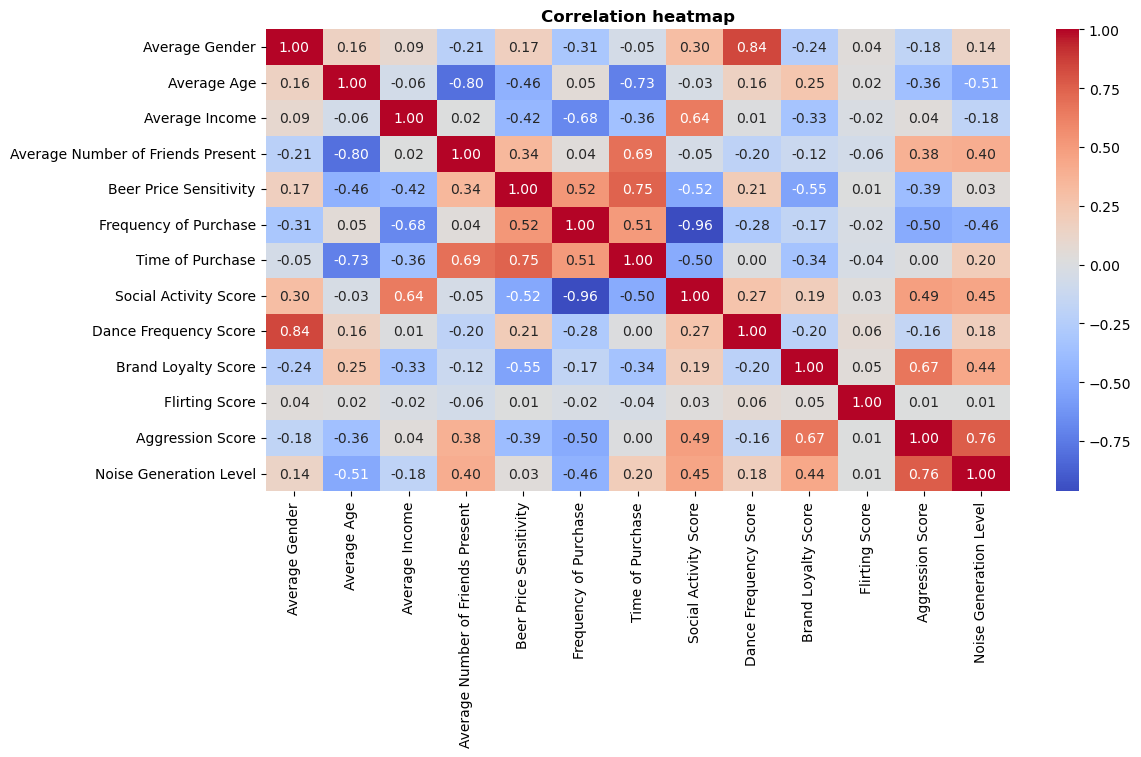

In [253]:
correlation_matrix = df.corr()

plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.title('Correlation heatmap', fontweight='bold')
plt.show()

# 2. Clustering models

# 2.1. K-means

In [255]:
# trying different n_init_values with fixed K_value
K = 19
n_init_values = [5, 10, 20, 30, 50, 70, 100, 120]

losses = []
k_means_models = []

for n_init_value in n_init_values:
    k_means_model = KMeans(n_clusters=K, n_init=n_init_value, random_state=26).fit(df)
    loss = - k_means_model.score(df)

    losses.append(loss)
    k_means_models.append(k_means_model)

losses

[2712.374554828935,
 2696.6447282889076,
 2670.072665877221,
 2657.4252662926156,
 2656.613443645826,
 2656.613443645826,
 2649.9551922458254,
 2649.9551922458254]

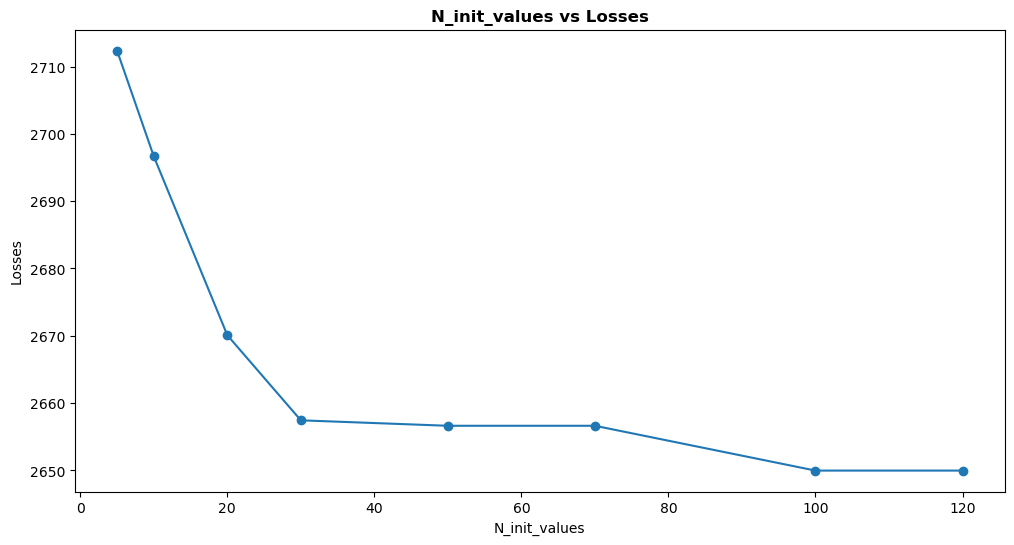

In [256]:
# plot the dependence between n_init_values and Losses
plt.figure(figsize=(12,6))
plt.plot(n_init_values, losses, marker='o')
plt.title('N_init_values vs Losses', fontweight='bold')
plt.xlabel('N_init_values')
plt.ylabel('Losses')
plt.show()

In [257]:
# trying different K_values with fixed n_init
K_values = range(1,20)
n_init = 100

losses = []

for K_value in K_values:
    k_means_model = KMeans(n_clusters=K_value, n_init=n_init, random_state=26).fit(df)
    loss = - k_means_model.score(df)

    losses.append(loss)

losses

[152056.96599999996,
 61208.57075039111,
 29851.25033734742,
 18285.669898262564,
 11065.354952831429,
 8748.001822222166,
 6822.108670747019,
 5317.124295747019,
 4544.896664289938,
 4166.437788320945,
 3817.593145463803,
 3495.3108240352317,
 3183.1239503968873,
 3042.8209186833574,
 2919.5218097749894,
 2830.1949637402895,
 2765.0612576918293,
 2707.328458595108,
 2649.9551922458254]

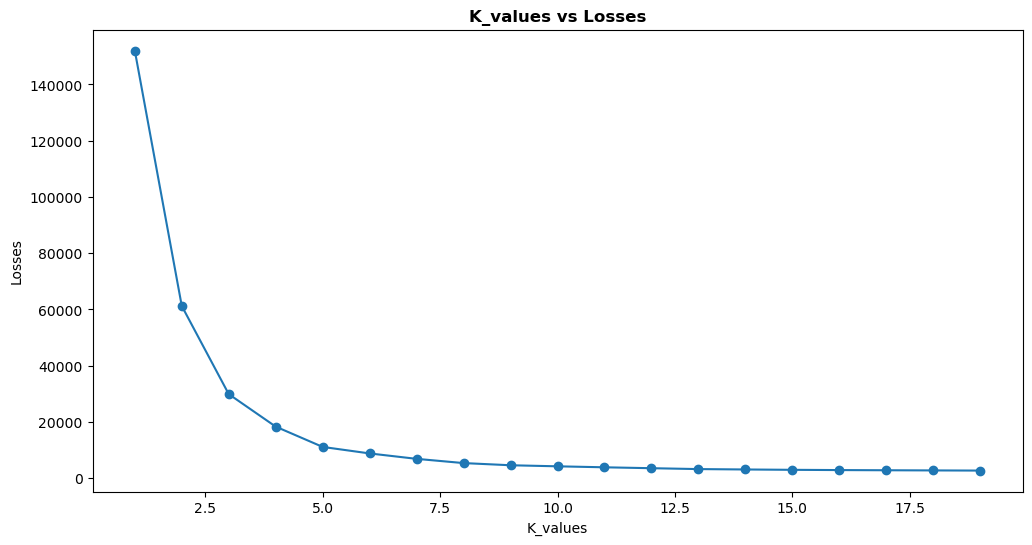

In [258]:
# plot the dependence between K_values and Losses  
plt.figure(figsize=(12,6))
plt.plot(K_values, losses, marker='o')
plt.title('K_values vs Losses', fontweight='bold')
plt.xlabel('K_values')
plt.ylabel('Losses')
plt.show()

In [259]:
# trying different both n_init_values and K_values
K_values = range(1,21)
n_init_values = [5, 10, 20, 30, 50, 70, 100, 120]

losses_dict = {n_init: [] for n_init in n_init_values}

for K_value in K_values:
    for n_init in n_init_values:
        k_means_model = KMeans(n_clusters=K_value, n_init=n_init, random_state=26).fit(df)
        loss = - k_means_model.score(df)

        losses_dict[n_init].append(loss)

losses

[152056.96599999996,
 61208.57075039111,
 29851.25033734742,
 18285.669898262564,
 11065.354952831429,
 8748.001822222166,
 6822.108670747019,
 5317.124295747019,
 4544.896664289938,
 4166.437788320945,
 3817.593145463803,
 3495.3108240352317,
 3183.1239503968873,
 3042.8209186833574,
 2919.5218097749894,
 2830.1949637402895,
 2765.0612576918293,
 2707.328458595108,
 2649.9551922458254]

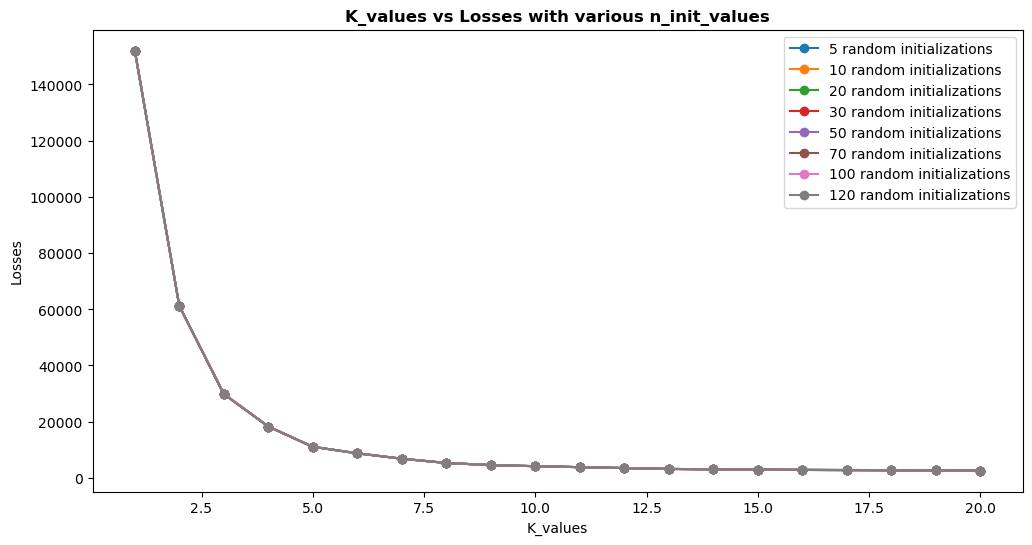

In [260]:
# plot the dependence between K_values with different n_init_values and Losses
plt.figure(figsize=(12,6))

for n_init, losses in losses_dict.items():
    plt.plot(K_values, losses, marker='o', label=f'{n_init} random initializations')

plt.legend()
plt.title('K_values vs Losses with various n_init_values', fontweight='bold')
plt.xlabel('K_values')
plt.ylabel('Losses')
plt.show()

# PCA

In [261]:
# Standardize the data
df_standardized = StandardScaler().fit_transform(df)

In [262]:
# Use PCA to further build a 2D graph
pca_13d_to_2d = PCA(n_components=2)
df_pca = pca_13d_to_2d.fit_transform(df_standardized)

* Back to the K-means

In [263]:
# K-means model
k_means_model = KMeans(n_clusters=5, n_init=50, init='k-means++', random_state=26)
k_means_model.fit(df_standardized)

labels_k_means = k_means_model.predict(df_standardized)

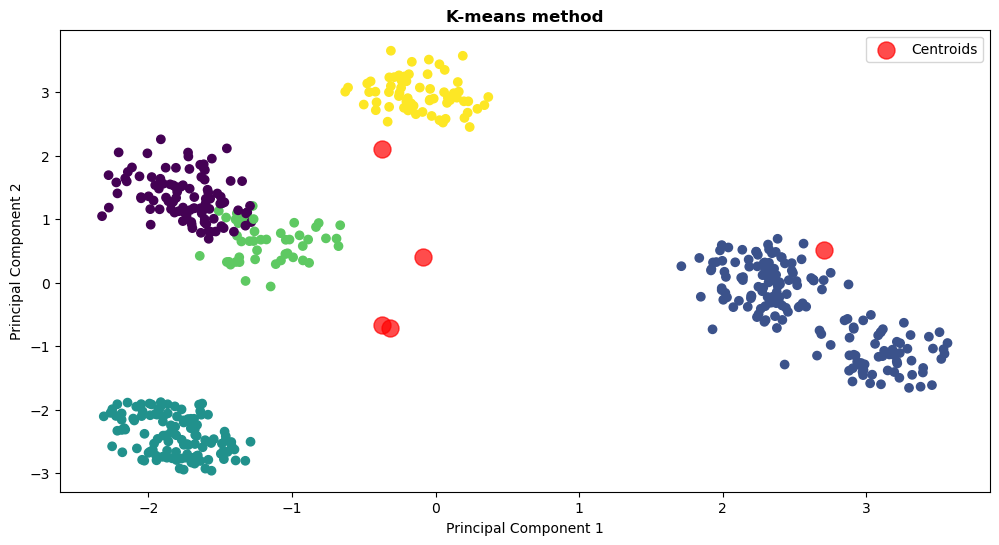

In [264]:
# plot K-means model
_, axis = plt.subplots(figsize=(12,6))
axis.scatter(df_pca[:, 0], df_pca[:, 1], c=labels_k_means)
axis.scatter(k_means_model.cluster_centers_[:, 0], k_means_model.cluster_centers_[:, 1], c='red', s=150, alpha=0.7, label='Centroids')
plt.title('K-means method', fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# 2.2. EM-method

In [265]:
# EM model
EM_model = GaussianMixture(n_components=6, random_state=26)
EM_model.fit(df_standardized)

labels_em = EM_model.predict(df_standardized)
centers_em = EM_model.means_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


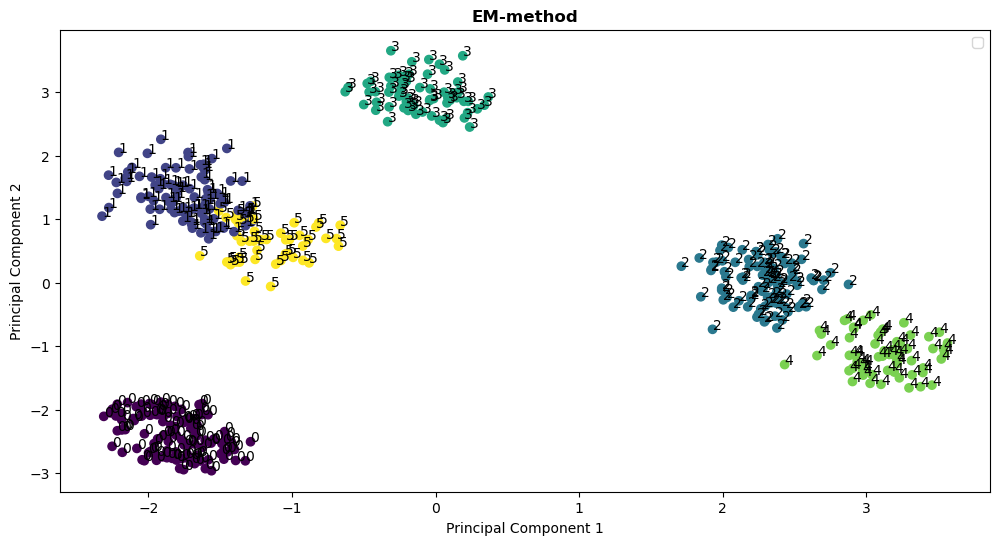

In [266]:
# plot EM-model
_, axis = plt.subplots(figsize=(12,6))
axis.scatter(df_pca[:, 0], df_pca[:, 1], c=labels_em)
# axis.scatter(centers_em[:, 0], centers_em[:, 1], s=150, alpha=0.7, label='Centers', c='red')

# Add an annotation to each point
for i in range(len(df_pca)):
    axis.annotate(labels_em[i], (df_pca[i, 0], df_pca[i, 1]))

plt.title('EM-method', fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# 2.3. Agglomerative clustering 

In [267]:
# Agglomerative clustering model
agglomerative_model = AgglomerativeClustering(n_clusters=6, linkage='ward')
labels_agglomerative = agglomerative_model.fit_predict(df_standardized)

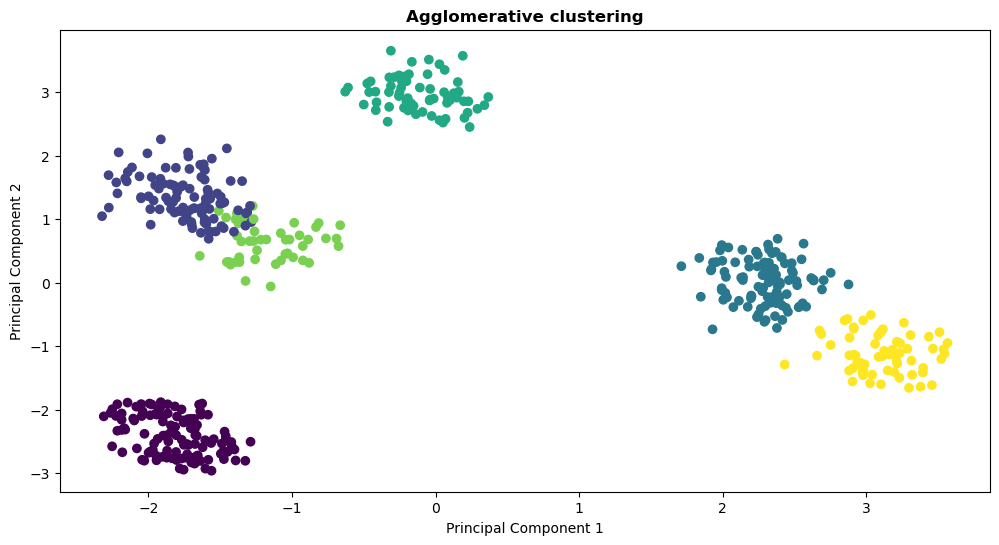

In [268]:
# Plot agglomerative model
_, axis = plt.subplots(figsize=(12,6))
axis.scatter(df_pca[:,0], df_pca[:,1], c=labels_agglomerative)
plt.title('Agglomerative clustering', fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

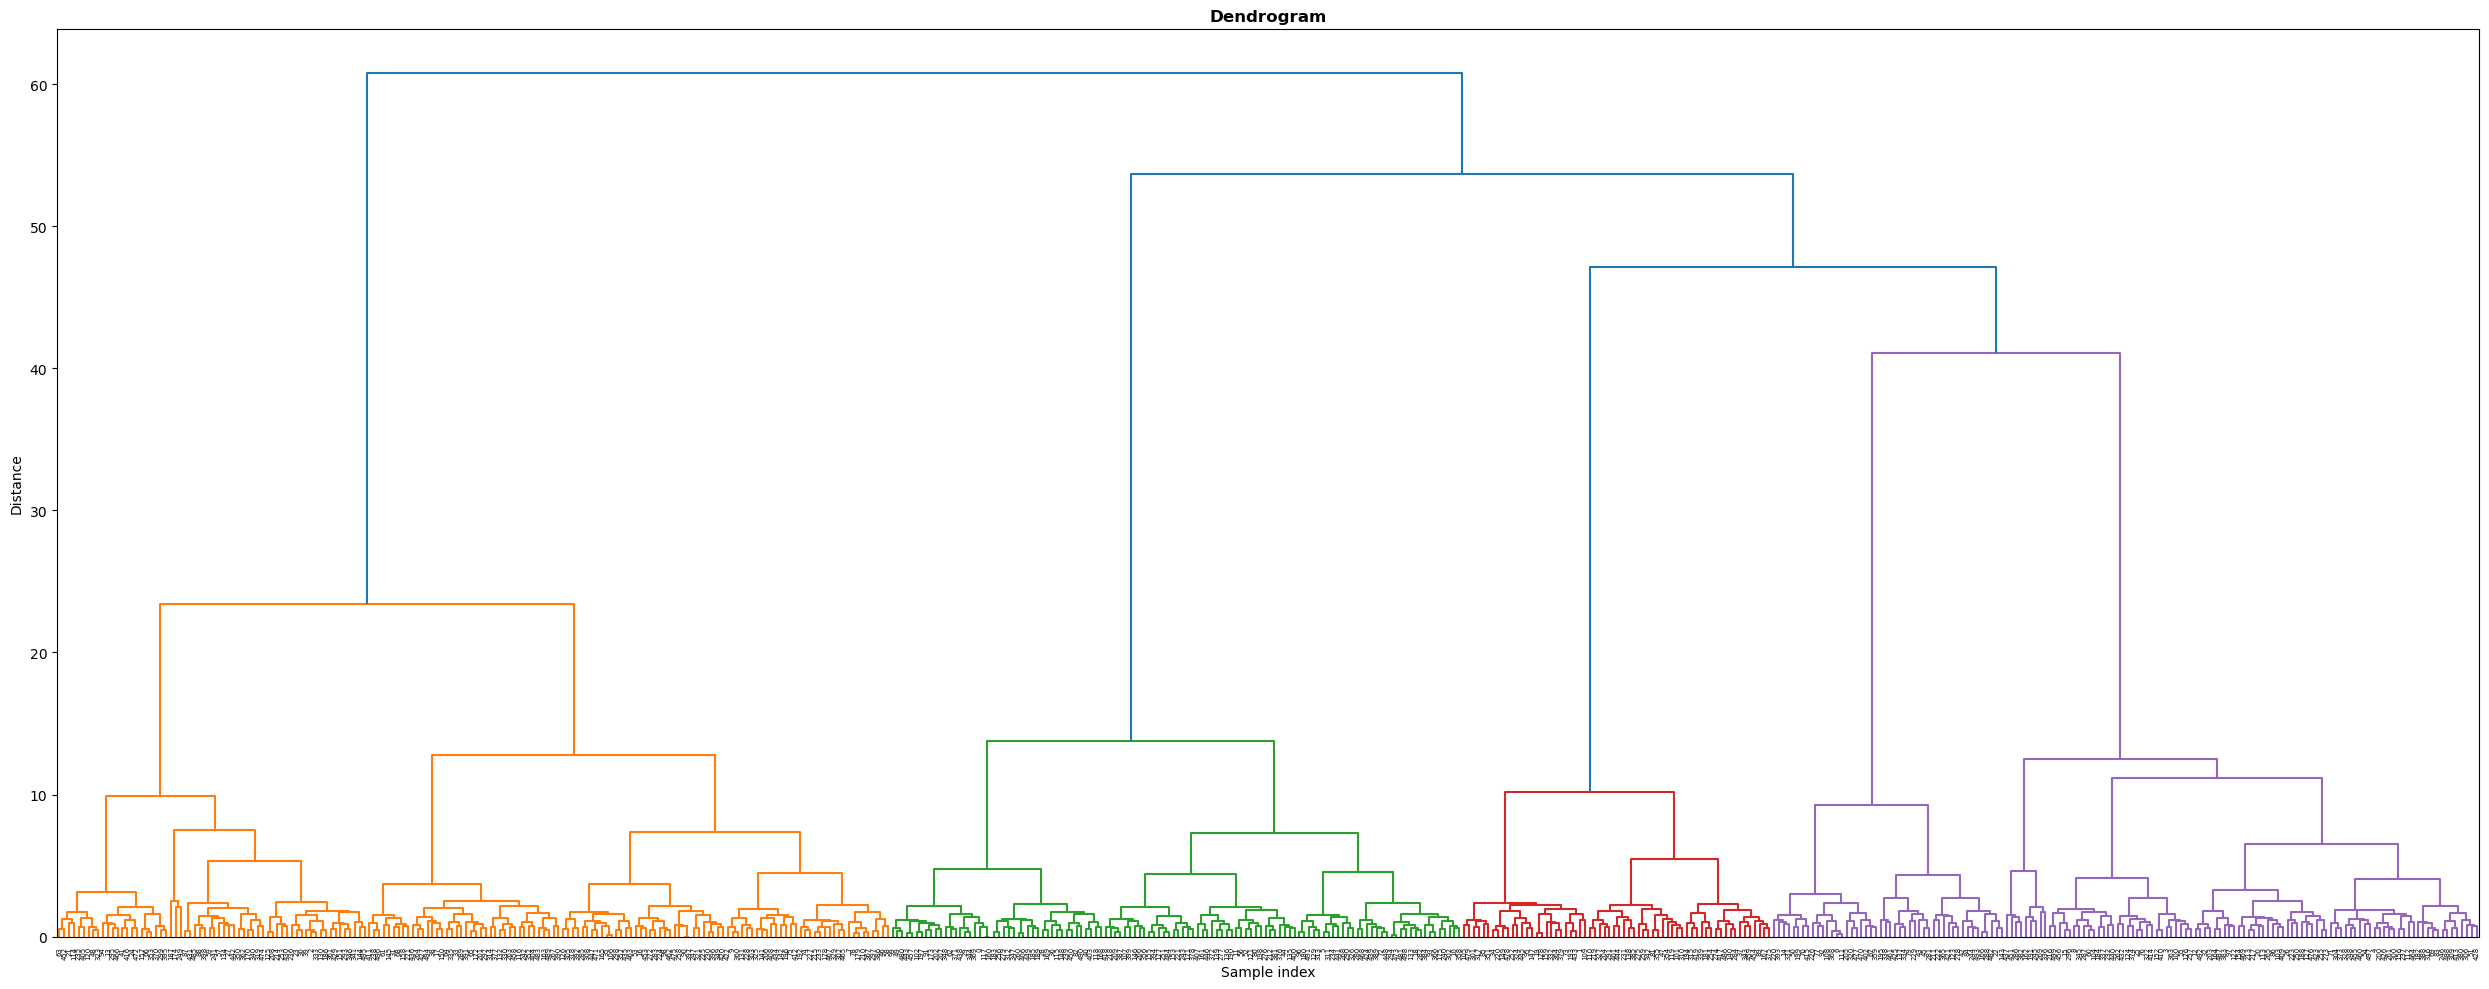

In [269]:
# Dendrogram
linkage_matrix = linkage(df_standardized, method='ward')
plt.figure(figsize=(25,10))
dendrogram(linkage_matrix)
plt.title('Dendrogram', fontweight='bold')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# 2.4. DBSCAN

In [270]:
# DBSCAN model: 5 clusters without outliers
dbscan_model = DBSCAN(eps=3.3, min_samples=10)
clusters_dbscan = dbscan_model.fit_predict(df_standardized)

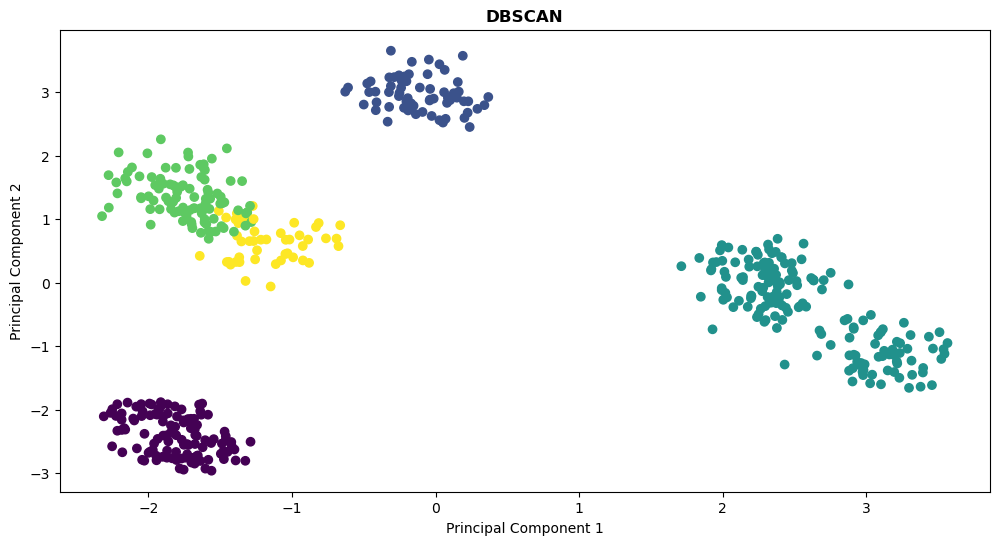

In [271]:
# Plot DBSCAN model
_, axis = plt.subplots(figsize=(12,6))
axis.scatter(df_pca[:,0], df_pca[:,1], c=clusters_dbscan)
plt.title('DBSCAN', fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [272]:
# DBSCAN model: 6 clusters with outliers
dbscan_model = DBSCAN(eps=1.8, min_samples=6)
clusters_dbscan = dbscan_model.fit_predict(df_standardized)

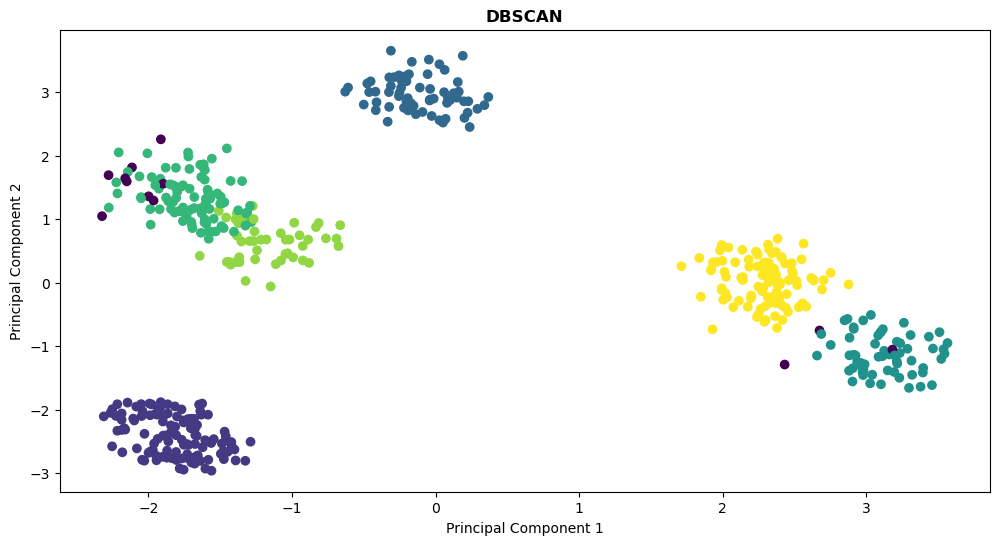

In [345]:
# Plot DBSCAN model
_, axis = plt.subplots(figsize=(12,6))
axis.scatter(df_pca[:,0], df_pca[:,1], c=clusters_dbscan)
    
plt.title('DBSCAN', fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [274]:
clusters_dbscan[clusters_dbscan == -1]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

# 2.5. HDBSCAN

In [275]:
hdbscan_model = HDBSCAN(min_samples=9, min_cluster_size=10)
clusters_hdbscan = hdbscan_model.fit_predict(df_standardized)

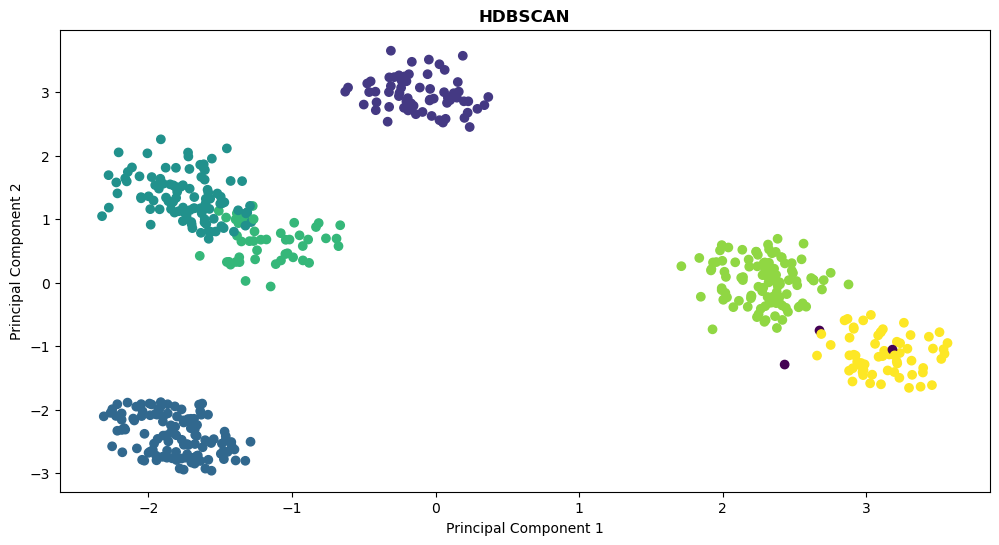

In [276]:
# Plot HDBSCAN model
_, axis = plt.subplots(figsize=(12,6))
axis.scatter(df_pca[:,0], df_pca[:,1], c=clusters_hdbscan)
plt.title('HDBSCAN', fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [277]:
clusters_hdbscan[clusters_hdbscan == -1]

array([-1, -1, -1], dtype=int64)

# 3. Interpretation of clusters